In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
from implementations import *
from preprocess import *
from cross_validation import *

***Load the training data into feature matrix, class labels, and event ids***

In [3]:
DATA_TRAIN_PATH = './data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

***Preprocessing the data***

In [8]:
y_train, tx_train = preprocess_data(y, tX)

***Code***

In [9]:
##### Least squares test sans build-poly

# Ajout d'offset
tx_train1 = np.c_[np.ones((y_train.shape[0], 1)), tx_train]

x_tr, x_te, y_tr, y_te = split_data(tx_train1, y_train, 0.5)
loss_LS, w_LS = least_squares(y_tr, x_tr)

In [7]:
y_validation_tr = predict_labels(w_LS, x_tr)
accuracy_tr = sum(y_validation_tr == y_tr)/len(y_tr)
print('Accuracy for LS (S train):', accuracy_tr)

y_validation_te = predict_labels(w_LS, x_te)
accuracy_te = sum(y_validation_te == y_te)/len(y_te)
print('Accuracy for LS (S test):', accuracy_te)

Accuracy for LS (S train): 0.745352
Accuracy for LS (S test): 0.742904


***Choix du meilleur degré pour least sqaures avec build poly***

In [8]:
def cross_validation_LS(y, x, k_indices, k, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train:
    xTest= x[k_indices[k]]
    yTest = y[k_indices[k]]
    
    A = np.ones(y.shape, dtype = bool)
    A[:]=True
    A[k_indices[k]] = False
    
    xTrain=x[A]
    yTrain = y[A]
    
    # form data with polynomial degree:
    polyTrain = build_poly(xTrain, degree)
    polyTest = build_poly(xTest, degree)
    
    # ridge regression:
    _, w = least_squares(yTrain, polyTrain)
    
    # calculate the accuracy for train and test data:
    y_validation_tr = predict_labels(w, polyTrain)
    accuracy_tr = sum(y_validation_tr == yTrain)/len(yTrain)
    y_validation_te = predict_labels(w, polyTest)
    accuracy_te = sum(y_validation_te == yTest)/len(yTest)
    return accuracy_tr, accuracy_te


Degre =  7
Train accuracy = 0.80414 +- 0.00105
Test accuracy  = 0.80380 +- 0.00366
Degre =  8
Train accuracy = 0.81137 +- 0.00126
Test accuracy  = 0.81073 +- 0.00332
Degre =  9
Train accuracy = 0.81499 +- 0.00093
Test accuracy  = 0.81399 +- 0.00360
Degre =  10
Train accuracy = 0.81670 +- 0.00083
Test accuracy  = 0.81568 +- 0.00294
Degre =  11
Train accuracy = 0.81518 +- 0.00501
Test accuracy  = 0.81501 +- 0.00636
Degre =  12
Train accuracy = 0.81936 +- 0.00077
Test accuracy  = 0.81806 +- 0.00332
Degre =  13
Train accuracy = 0.75452 +- 0.09990
Test accuracy  = 0.75431 +- 0.09992
Degre =  14
Train accuracy = 0.80372 +- 0.01581
Test accuracy  = 0.80332 +- 0.01706
Degre =  15
Train accuracy = 0.77153 +- 0.05245
Test accuracy  = 0.77093 +- 0.05244
Best degree for Least Squares: 12


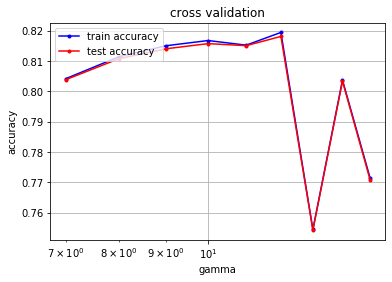

In [32]:
def cross_validation_demo_LS(x, y):
    seed = 1
    degrees = range(7,16)
    k_fold = 5
    
    # split data into traing set and testing set
    x_tr, x_te, y_tr, y_te = split_data(x, y, 0.72)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the accuracy of training data and test data
    accuracy_te_mean = []
    accuracy_tr_mean = []
    accuracy_tr_std = []
    accuracy_te_std = []
    
    # cross validation:
    for deg in degrees:
        accuracy_tr = []
        accuracy_te = []
        print("Degre = ", deg)
        
        for k in range (k_fold):
            accuracy_tr_tmp, accuracy_te_tmp = cross_validation_LS(y_tr, x_tr, k_indices, k, deg)
            accuracy_tr.append(accuracy_tr_tmp)
            accuracy_te.append(accuracy_te_tmp)
        
        accuracy_tr_mean.append(np.mean(accuracy_tr))
        accuracy_te_mean.append(np.mean(accuracy_te))
        accuracy_tr_std.append(np.std(accuracy_tr))
        accuracy_te_std.append(np.std(accuracy_te))
        print("Train accuracy = {:.5f} +- {:.5f}".format(accuracy_tr_mean[-1], accuracy_tr_std[-1]))
        print("Test accuracy  = {:.5f} +- {:.5f}".format(accuracy_te_mean[-1], accuracy_te_std[-1]))
    
    cross_validation_visualization(degrees, accuracy_tr_mean, accuracy_te_mean)
    best_degree = degrees[np.nanargmax(accuracy_te_mean)]
    print("Best degree for Least Squares:", best_degree)
    
cross_validation_demo_LS(tx_train, y_train)

In [ ]:
##### Least squares
x_tr, x_te, y_tr, y_te = split_data(tx_train, y_train, 0.4)
px_tr = build_poly(x_tr, 12)
px_te = build_poly(x_te, 12)
loss, w_LS = least_squares(y_tr, px_tr)

In [30]:
y_validation_tr = predict_labels(w_LS, px_tr)
accuracy_tr = sum(y_validation_tr == y_tr)/len(y_tr)
print('Accuracy for LS (S train):', accuracy_tr)

y_validation_te = predict_labels(w_LS, px_te)
accuracy_te = sum(y_validation_te == y_te)/len(y_te)
print('Accuracy for LS (S test):', accuracy_te)

Accuracy for LS (S train): 0.81957
Accuracy for LS (S test): 0.81866


***GD/SGD***

In [33]:
def cross_validation_GD(y, x, k_indices, k, degree, gamma, max_iters):
    # get k'th subgroup in test, others in train:
    xTest= x[k_indices[k]]
    yTest = y[k_indices[k]]
    
    A = np.ones(y.shape, dtype = bool)
    A[:]=True
    A[k_indices[k]] = False
    
    xTrain=x[A]
    yTrain = y[A]
    
    # form data with polynomial degree:
    polyTrain = build_poly(xTrain, degree)
    polyTest = build_poly(xTest, degree)
    
    # initialize the weight
    initial_w = np.zeros(polyTrain.shape[1], dtype=np.float64)
    
    # Gradient descent:
    _, w = least_squares_GD(yTrain, polyTrain, initial_w, max_iters, gamma)
    
    # calculate the accuracy for train and test data:
    y_validation_tr = predict_labels(w, polyTrain)
    accuracy_tr = sum(y_validation_tr == yTrain)/len(yTrain)
    y_validation_te = predict_labels(w, polyTest)
    accuracy_te = sum(y_validation_te == yTest)/len(yTest)
    return accuracy_tr, accuracy_te
    


Gamma =  0.1
Train accuracy = 0.74183 +- 0.00070
Test accuracy  = 0.74193 +- 0.00187
Gamma =  0.2
Train accuracy = 0.74370 +- 0.00085
Test accuracy  = 0.74356 +- 0.00222
Gamma =  0.3
Train accuracy = 0.74425 +- 0.00079
Test accuracy  = 0.74391 +- 0.00248


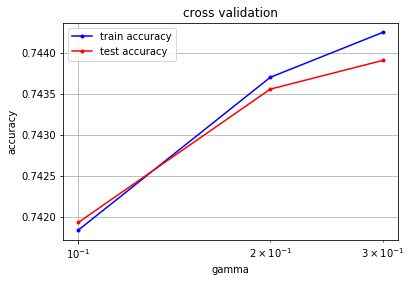

In [42]:
def cross_validation_demo_GD(x, y):
    seed = 1
    degree = 1
    gammas = [0.1, 0.2, 0.3]
    k_fold = 5
    max_iters = 100
    
    # split data into traing set and testing set
    x_tr, x_te, y_tr, y_te = split_data(x, y, 0.72)
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the accuracy of training data and test data
    accuracy_te_mean = []
    accuracy_tr_mean = []
    accuracy_tr_std = []
    accuracy_te_std = []
    
    # cross validation:
        
    for gam in gammas:
        accuracy_tr = []
        accuracy_te = []
        print("Gamma = ", gam)
            
        for k in range (k_fold):
            accuracy_tr_tmp, accuracy_te_tmp = cross_validation_GD(y_tr, x_tr, k_indices, k, degree, gam, max_iters)
            accuracy_tr.append(accuracy_tr_tmp)
            accuracy_te.append(accuracy_te_tmp)

        accuracy_tr_mean.append(np.mean(accuracy_tr))
        accuracy_te_mean.append(np.mean(accuracy_te))
        accuracy_tr_std.append(np.std(accuracy_tr))
        accuracy_te_std.append(np.std(accuracy_te))
        print("Train accuracy = {:.5f} +- {:.5f}".format(accuracy_tr_mean[-1], accuracy_tr_std[-1]))
        print("Test accuracy  = {:.5f} +- {:.5f}".format(accuracy_te_mean[-1], accuracy_te_std[-1]))
    
    cross_validation_visualization(gammas, accuracy_tr_mean, accuracy_te_mean)
    
cross_validation_demo_GD(tx_train, y_train)

In [17]:
##### GD/SGD test
max_iters = 100

#y_tr = np.expand_dims(y_tr, axis=1)
#y_te = np.expand_dims(y_te, axis=1)

px_tr = build_poly(x_tr, best_deg)
px_te = build_poly(x_te, best_deg)

w_i = np.zeros(px_tr.shape[1], dtype=np.float64)
#loss_i, w_i = least_squares(y_tr, x_tr)
#print(y_tr.shape, px_tr.shape, w.shape)
loss_SG, w_SG = least_squares_SGD(y_tr, px_tr, w_i, 1000, max_iters, best_gamma)
print("Loss SG : \n", loss_SG)
print("Weight SG: \n", w_SG)

Loss SG : 
 0.8287917535395751
Weight SG: 
 [-0.30222245 -0.02575243 -0.24092253 -0.1524161   0.0231199   0.03154093
  0.06396121  0.0039019   0.22162158 -0.0427225   0.04808127 -0.12896634
  0.12704938  0.06923638  0.18027872 -0.00685299 -0.00926354  0.18118864
 -0.00358819  0.00669544  0.07110459  0.00469846 -0.04281691 -0.05563729
  0.01142301  0.01239324 -0.04271429 -0.00561273 -0.00231332]


In [18]:
y_validation_tr = predict_labels(w_SG, px_tr)
accuracy_tr = sum(y_validation_tr == y_tr)/len(y_tr)
print('Accuracy for GD (S train):', accuracy_tr)

y_validation_te = predict_labels(w_SG, px_te)
accuracy_te = sum(y_validation_te == y_te)/len(y_te)
print('Accuracy for GD (S test):', accuracy_te)

Accuracy for GD (S train): 0.7434111111111111
Accuracy for GD (S test): 0.7426


***Ridge***

In [7]:
def cross_validation_ridge(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train:
    xTest= x[k_indices[k]]
    yTest = y[k_indices[k]]
    
    A = np.ones(y.shape, dtype = bool)
    A[:]=True
    A[k_indices[k]] = False
    
    xTrain=x[A]
    yTrain = y[A]
    
    # form data with polynomial degree:
    polyTrain = build_poly(xTrain, degree)
    polyTest = build_poly(xTest, degree)
    
    # ridge regression:
    _, w = ridge_regression(yTrain, polyTrain, lambda_)
    
    # calculate the accuracy for train and test data:
    y_validation_tr = predict_labels(w, polyTrain)
    accuracy_tr = sum(y_validation_tr == yTrain)/len(yTrain)
    y_validation_te = predict_labels(w, polyTest)
    accuracy_te = sum(y_validation_te == yTest)/len(yTest)
    return accuracy_tr, accuracy_te
    


lambda =  2e-06
[0.7653714285714286, 0.80385, 0.8021714285714285, 0.7863071428571429, 0.79265]
[0.7632857142857142, 0.8016857142857143, 0.8007428571428571, 0.7899142857142857, 0.7895142857142857]
Train accuracy = 0.79007 +- 0.01391
Test accuracy  = 0.78903 +- 0.01386
lambda =  6.324555320336758e-06
[0.794, 0.8038571428571428, 0.7744642857142857, 0.8012357142857143, 0.7932071428571429]
[0.7910571428571429, 0.8016857142857143, 0.7686, 0.8035428571428571, 0.7914571428571429]
Train accuracy = 0.79335 +- 0.01029
Test accuracy  = 0.79127 +- 0.01243
lambda =  2e-05
[0.80205, 0.8038285714285714, 0.7973214285714286, 0.7988571428571428, 0.7803642857142857]
[0.7988, 0.8014857142857142, 0.7961714285714285, 0.8001714285714285, 0.7768285714285714]
Train accuracy = 0.79648 +- 0.00838
Test accuracy  = 0.79469 +- 0.00910
lambda =  6.324555320336759e-05
[0.8009714285714286, 0.8038071428571428, 0.7669, 0.8016357142857143, 0.75105]
[0.7973428571428571, 0.8016, 0.7673142857142857, 0.8054, 0.751971428571428

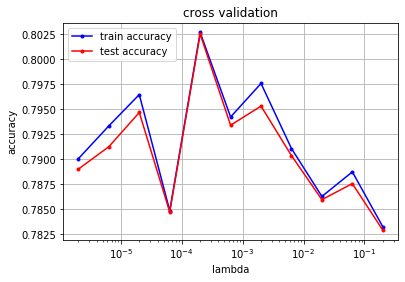

In [25]:
def cross_validation_demo_ridge(x, y):
    seed = 1
    degree = 7
    k_fold = 5
    lambdas = 2*np.logspace(-6, -1, 11)
    
    # split data into traing set and testing set
    x_tr, x_te, y_tr, y_te = split_data(x, y, 0.7)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the accuracy of training data and test data
    accuracy_te_mean = []
    accuracy_tr_mean = []
    accuracy_tr_std = []
    accuracy_te_std = []
    
    # cross validation:
    for lambda_ in lambdas:
        accuracy_tr = []
        accuracy_te = []
        print("lambda = ", lambda_)
        
        for k in range (k_fold):
            accuracy_tr_tmp, accuracy_te_tmp = cross_validation_ridge(y_tr, x_tr, k_indices, k, lambda_, degree)
            accuracy_tr.append(accuracy_tr_tmp)
            accuracy_te.append(accuracy_te_tmp)
        
        print(accuracy_tr)
        print(accuracy_te)
        accuracy_tr_mean.append(np.mean(accuracy_tr))
        accuracy_te_mean.append(np.mean(accuracy_te))
        accuracy_tr_std.append(np.std(accuracy_tr))
        accuracy_te_std.append(np.std(accuracy_te))
        print("Train accuracy = {:.5f} +- {:.5f}".format(accuracy_tr_mean[-1], accuracy_tr_std[-1]))
        print("Test accuracy  = {:.5f} +- {:.5f}".format(accuracy_te_mean[-1], accuracy_te_std[-1]))
    
    cross_validation_visualization(lambdas, accuracy_tr_mean, accuracy_te_mean)
    
cross_validation_demo_ridge(tx_train, y_train)

In [24]:
##### Ridge test
x_tr, x_te, y_tr, y_te = split_data(tx_train, y_train, 0.72)
px_tr = build_poly(x_tr, 7)
px_te = build_poly(x_te, 7)
loss, w_ridge= ridge_regression(y_tr, px_tr, 2e-4)

print("Loss ridge : \n", loss)
# print("Weight ridge : \n", w)

Loss ridge : 
 0.7600962235201505


In [25]:
y_validation_tr = predict_labels(w_ridge, px_tr)
accuracy_tr = sum(y_validation_tr == y_tr)/len(y_tr)
print('Accuracy for Ridge (S train):', accuracy_tr)

y_validation_te = predict_labels(w_ridge, px_te)
accuracy_te = sum(y_validation_te == y_te)/len(y_te)
print('Accuracy for Ridge (S test):', accuracy_te)

Accuracy for Ridge (S train): 0.8034777777777777
Accuracy for Ridge (S test): 0.8045428571428571


***Logistic regression***

In [51]:
def cross_validation_log(y, x, k_indices, k, lambda_, gamma, degree, max_iters):
    # get k'th subgroup in test, others in train:
    xTest= x[k_indices[k]]
    yTest = y[k_indices[k]]
    
    A = np.ones(y.shape, dtype = bool)
    A[:]=True
    A[k_indices[k]] = False
    
    xTrain=x[A]
    yTrain = y[A]
    
    # form data with polynomial degree:
    polyTrain = build_poly(xTrain, degree)
    polyTest = build_poly(xTest, degree)
    
    # initialize weights
    initial_w = np.zeros(polyTrain.shape[1], dtype=np.float64)
    
    # logistic regression:
    _, w = logistic_regression(yTrain, polyTrain, initial_w, max_iters, gamma, lambda_)
    
    # calculate the accuracy for train and test data:
    y_validation_tr = predict_labels(w, polyTrain)
    accuracy_tr = sum(y_validation_tr == yTrain)/len(yTrain)
    y_validation_te = predict_labels(w, polyTest)
    accuracy_te = sum(y_validation_te == yTest)/len(yTest)
    return accuracy_tr, accuracy_te

gamma =  5e-10
Train accuracy = 0.70665 +- 0.00047
Test accuracy  = 0.70664 +- 0.00241
gamma =  5e-09
Train accuracy = 0.70679 +- 0.00054
Test accuracy  = 0.70691 +- 0.00234
gamma =  5e-08
Train accuracy = 0.70757 +- 0.00055
Test accuracy  = 0.70754 +- 0.00206
gamma =  5e-07
Train accuracy = 0.71039 +- 0.00068
Test accuracy  = 0.71038 +- 0.00300
gamma =  5e-06
Train accuracy = 0.71458 +- 0.00073
Test accuracy  = 0.71469 +- 0.00244
gamma =  5e-05
Train accuracy = 0.71454 +- 0.00068
Test accuracy  = 0.71466 +- 0.00256
gamma =  0.0005
Train accuracy = 0.71455 +- 0.00068
Test accuracy  = 0.71467 +- 0.00256
gamma =  0.005
Train accuracy = 0.71455 +- 0.00069
Test accuracy  = 0.71467 +- 0.00256
gamma =  0.05
Train accuracy = 0.71455 +- 0.00069
Test accuracy  = 0.71467 +- 0.00256
gamma =  0.5
Train accuracy = 0.71455 +- 0.00069
Test accuracy  = 0.71467 +- 0.00256
gamma =  1
Train accuracy = 0.71455 +- 0.00069
Test accuracy  = 0.71467 +- 0.00256


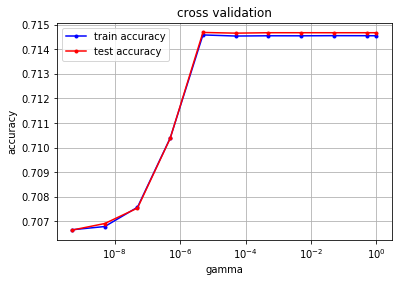

In [61]:
def cross_validation_demo_log(x, y):
    seed = 1
    degree = 1
    gammas = [5e-10, 5e-9, 5e-8, 5e-7, 5e-6, 5e-5, 5e-4, 5e-3, 5e-2, 5e-1, 1]
    k_fold = 5
    lambda_ = 2
    max_iters = 100
    
    # split data into traing set and testing set
    x_tr, x_te, y_tr, y_te = split_data(x, y, 0.7)
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the accuracy of training data and test data
    accuracy_te_mean = []
    accuracy_tr_mean = []
    accuracy_tr_std = []
    accuracy_te_std = []
    
    # cross validation:
    for gamma in gammas:
        accuracy_tr = []
        accuracy_te = []
        print("gamma = ", gamma)

        for k in range (k_fold):
            accuracy_tr_tmp, accuracy_te_tmp = cross_validation_log(y_tr, x_tr, k_indices, k, lambda_, gamma, degree, max_iters)
            accuracy_tr.append(accuracy_tr_tmp)
            accuracy_te.append(accuracy_te_tmp)

        accuracy_tr_mean.append(np.mean(accuracy_tr))
        accuracy_te_mean.append(np.mean(accuracy_te))
        accuracy_tr_std.append(np.std(accuracy_tr))
        accuracy_te_std.append(np.std(accuracy_te))
        print("Train accuracy = {:.5f} +- {:.5f}".format(accuracy_tr_mean[-1], accuracy_tr_std[-1]))
        print("Test accuracy  = {:.5f} +- {:.5f}".format(accuracy_te_mean[-1], accuracy_te_std[-1]))

    
cross_validation_demo_log(tx_train, y_train)

In [14]:
initial_w = np.zeros(x_tr.shape[1], dtype=np.float64)
loss_log, w_log = logistic_regression(y_tr, x_tr, initial_w, 10, 5e-6)

In [15]:
y_validation_tr = predict_labels(w_log, x_tr)
accuracy_tr = sum(y_validation_tr == y_tr)/len(y_tr)
print('Accuracy for regularized logistic regression:', accuracy_tr)

y_validation_te = predict_labels(w_log, x_te)
accuracy_te = sum(y_validation_te == y_te)/len(y_te)
print('Accuracy for regularized logistic regression:', accuracy_te)

Accuracy for regularized logistic regression: 0.710832
Accuracy for regularized logistic regression: 0.710056
